# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [124]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [125]:
# Load in the general demographics data.
azdias = pd.read_csv('./Udacity_AZDIAS_Subset.csv',delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv',delimiter=';')

In [126]:
azdias.shape

(891221, 85)

In [127]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
#demographic's info
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [128]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [129]:
feat_info.shape

(85, 4)

In [130]:
#features'info
feat_info.sample(15)

,attribute,information_level,type,missing_or_unknown
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
34,SEMIO_DOM,person,ordinal,"[-1,9]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
37,SEMIO_TRADV,person,ordinal,"[-1,9]"
4,FINANZ_MINIMALIST,person,ordinal,[-1]
72,ONLINE_AFFINITAET,region_rr1,ordinal,[]
65,KBA05_GBZ,microcell_rr3,ordinal,"[-1,0]"
44,ANZ_PERSONEN,household,numeric,[]
62,KBA05_ANTG3,microcell_rr3,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [131]:
# coping the dataset 
df_azdias = pd.read_csv('./Udacity_AZDIAS_Subset.csv',delimiter=';')

In [132]:
# just checking 
#df_azdias.info()

In [133]:
# Identify missing or unknown data values and convert them to NaNs.

# creating a list for missing/unknown data
feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: x[1:-1].split(','))

#looping over the two coloumns checked in "feat_info.head()"
for attribute, missing_values in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
    if missing_values[0] != '':
        for value in missing_values:
            # checking whether the string consists of only numeric characters, dropping ('-') for assurity 
            if value.isnumeric() or value.lstrip('-').isnumeric():  
                value = int(value)
            df_azdias.loc[df_azdias[attribute] == value, attribute] = np.nan

In [134]:
df_azdias.isnull().sum()

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [135]:
df_azdias.isnull().sum().sum()

8373929

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [136]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_data = df_azdias.isnull().sum()
#get percentage
missing_data = missing_data[missing_data > 0]/(df_azdias.shape[0]) * 100
missing_data.sort_values(inplace=True)

#print(len(missing_data))

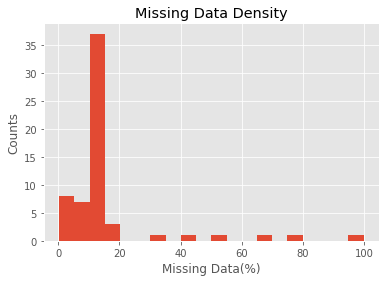

In [137]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(missing_data, 20)

plt.xlabel('Missing Data(%)')
plt.ylabel('Counts')
plt.title('Missing Data Density')
plt.grid(True)
plt.show()

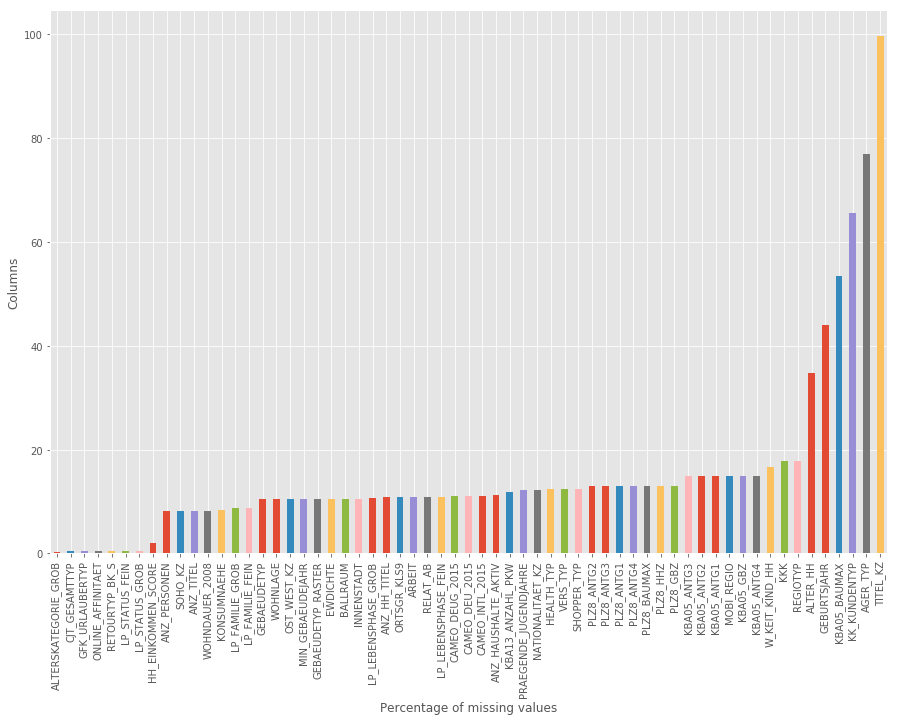

In [138]:
missing_data.plot.bar(figsize=(15,10))
plt.xlabel('Percentage of missing values')
plt.ylabel('Columns')
plt.show()

In [139]:
print('Percentage of Missing Data:',round(df_azdias.isnull().sum().sum()/np.product(df_azdias.shape)*100,3),'%')

Percentage of Missing Data: 11.054 %


In [140]:
Col_null = (df_azdias.isnull().mean()).sort_values(ascending=False)
Col_most_missingData = Col_null[Col_null>0.2]
print(Col_most_missingData)
print(len(Col_most_missingData))

TITEL_KZ        0.997576
AGER_TYP        0.769554
KK_KUNDENTYP    0.655967
KBA05_BAUMAX    0.534687
GEBURTSJAHR     0.440203
ALTER_HH        0.348137
dtype: float64
6


In [141]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
missing_20 = [col for col in df_azdias.columns 
               if (df_azdias[col].isnull().sum()/df_azdias.shape[0])* 100 > 20]

for col in missing_20:
    df_azdias.drop(col, axis=1, inplace=True)

In [142]:
print(missing_20)

['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [143]:
# check after dropping coloumns
df_azdias.shape

(891221, 79)

In [144]:
check_after_drop = df_azdias.isnull().sum()
check_after_drop = check_after_drop[check_after_drop> 0]/(df_azdias.shape[0]) * 100
#print(type(check_after_drop))
#check_after_drop.sort_values(ascending = False)

#### Discussion 1.1.2: Assess Missing Data in Each Column

According to the first histogram, we can conclude that several coloumns include missing/unknown information which could produce mess in data. For this reason, it's better to drop the unnecessary coloumns that doesn't hold a valuable information.
The second histogram gives a better visualization of the coloumns comparing with the amount of the missing data, and from which we could split the data into two categories:
- Coloumns with missing data **> 20%**
- Coloums with missing data **< 20%**

The coloumns exceeding the "20%" are considered unnecessary which are the **six** belowing:
- TITEL_KZ        
- AGER_TYP        
- KK_KUNDENTYP    
- KBA05_BAUMAX    
- GEBURTSJAHR     
- ALTER_HH 
THhey are **dropped**

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [145]:
# How much data is missing in each row of the dataset?
missing_Rdata = df_azdias.isnull().sum(axis=1)
missing_Rdata = missing_Rdata[missing_Rdata > 0]/(len(df_azdias.columns)) * 100
missing_Rdata.sort_values(inplace=True)
missing_Rdata.sort_values(ascending=False)

732775    62.025316
643174    62.025316
472919    60.759494
453262    59.493671
183601    59.493671
183599    59.493671
318281    59.493671
27533     59.493671
526991    59.493671
318320    59.493671
318321    59.493671
318322    59.493671
527002    59.493671
27531     59.493671
221169    59.493671
453260    59.493671
318326    59.493671
183499    59.493671
221224    59.493671
183496    59.493671
288864    59.493671
527051    59.493671
183492    59.493671
839537    59.493671
453376    59.493671
527069    59.493671
453402    59.493671
839529    59.493671
839556    59.493671
526503    59.493671
            ...    
664798     1.265823
2775       1.265823
110352     1.265823
544336     1.265823
309051     1.265823
674239     1.265823
309043     1.265823
110302     1.265823
664952     1.265823
308988     1.265823
308975     1.265823
110346     1.265823
884622     1.265823
664958     1.265823
884646     1.265823
884661     1.265823
747312     1.265823
308889     1.265823
884695     1.265823


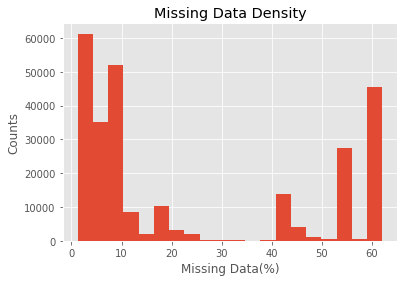

In [146]:
# visualizing data
plt.hist(missing_Rdata, 20)

plt.xlabel('Missing Data(%)')
plt.ylabel('Counts')
plt.title('Missing Data Density')
plt.grid(True)
plt.show()

In [147]:
# counting "null" data in rows-->axis=1
missing_Rdata = df_azdias.isnull().sum(axis=1)
missing_Rdata.sum()

5035304

In [148]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
missing_Low_rate = df_azdias[df_azdias.isnull().sum(axis=1) < 10].reset_index(drop=True)
missing_High_rate = df_azdias[df_azdias.isnull().sum(axis=1) >= 10].reset_index(drop=True)

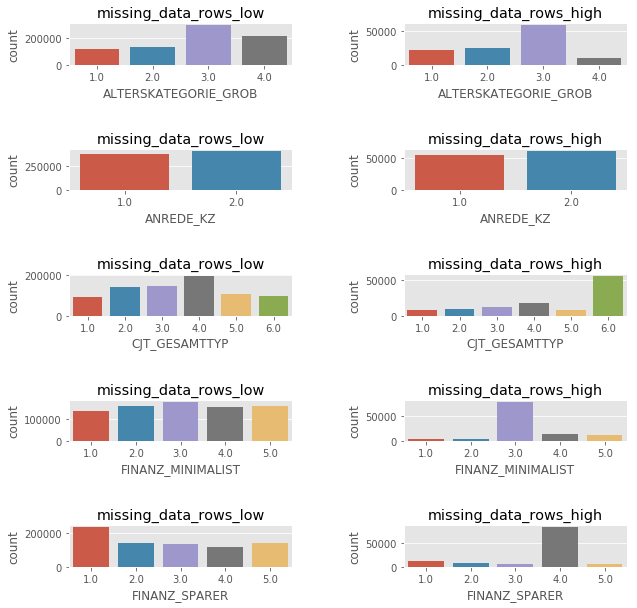

In [149]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# function for plotting
def countplot(columns, num):
    fig, axs = plt.subplots(num, 2, figsize=(10, 10))
    fig.subplots_adjust(hspace=2 , wspace=.5)
    #return a flattened 1D array
    axs = axs.ravel()
    
    for i in range(num):       
        sns.countplot(missing_Low_rate[columns[i]], ax=axs[i*2])
        axs[i*2].set_title('missing_data_rows_low')
        sns.countplot(missing_High_rate[columns[i]], ax=axs[i*2+1])
        axs[i*2+1].set_title('missing_data_rows_high')
        
countplot(missing_Low_rate.columns, 5)


In [150]:
print('Rows with High rate of missing data: ', missing_High_rate.shape[0])
print('Percentage: ',np.round(missing_High_rate.shape[0]*100/missing_Rdata.shape[0],3),'%')

Rows with High rate of missing data:  116478
Percentage:  13.069 %


In [151]:
# keeping the df of low missing data to work with
df_lowNaN = missing_Low_rate

In [152]:
df_lowNaN.shape

(774743, 79)

#### Discussion 1.1.3: Assess Missing Data in Each Row

- From the first plotted histogram, we could analyse that **10%** will be a good point for splitting the data into **two subsets**.
- About 13.07% are found with missing data with greater than 10%.
- From the second diagrams, the rows with missing data are different. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [153]:
feat_info = feat_info[feat_info.attribute.isin(df_azdias.columns)]
feat_info.shape

(79, 4)

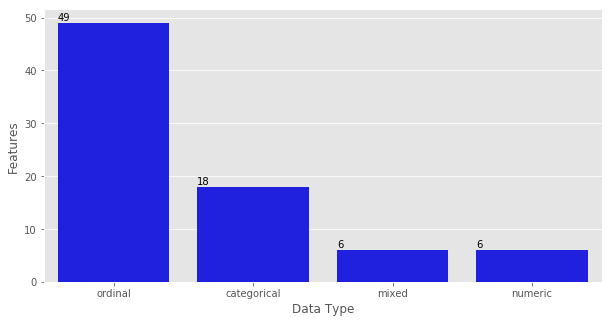

In [154]:
# How many features are there of each data type?
fig, ax1 = plt.subplots(figsize=(10,5))
sns.countplot(data=feat_info,
              x='type',
              color='b',
              ax=ax1)
ax1.set_ylabel('Features')
ax1.set_xlabel('Data Type')
for p in ax1.patches:
    ax1.annotate('{:.0f}'.format(p.get_height()), (p.get_x(), p.get_height()+0.5))
sns.despine(ax=ax1);

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [155]:
feat_info[feat_info.type == 'categorical']

,attribute,information_level,type,missing_or_unknown
2,ANREDE_KZ,person,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]
21,NATIONALITAET_KZ,person,categorical,"[-1, 0]"


In [156]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
feat_info[feat_info.type == 'categorical'].groupby('information_level').count().iloc[:,-1]

information_level
building          2
microcell_rr4     2
person           14
Name: missing_or_unknown, dtype: int64

In [157]:
df_categorical = feat_info[feat_info.type == 'categorical'].attribute
df_categorical

2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

In [158]:
df_lowNaN[df_categorical].nunique().sort_values()

ANREDE_KZ            2
OST_WEST_KZ          2
VERS_TYP             2
SOHO_KZ              2
GREEN_AVANTGARDE     2
NATIONALITAET_KZ     3
SHOPPER_TYP          4
LP_STATUS_GROB       5
LP_FAMILIE_GROB      5
FINANZTYP            6
ZABEOTYP             6
CJT_GESAMTTYP        6
GEBAEUDETYP          7
CAMEO_DEUG_2015      9
LP_STATUS_FEIN      10
LP_FAMILIE_FEIN     11
GFK_URLAUBERTYP     12
CAMEO_DEU_2015      44
dtype: int64

In [159]:
print('Sum of(2):', sum(df_lowNaN[df_categorical].nunique() == 2) ,'\nSum of greater than (2):',sum(df_lowNaN[df_categorical].nunique() > 2))

Sum of(2): 5 
Sum of greater than (2): 13


In [160]:
df_lowNaN[df_categorical].dtypes

ANREDE_KZ           float64
CJT_GESAMTTYP       float64
FINANZTYP           float64
GFK_URLAUBERTYP     float64
GREEN_AVANTGARDE      int64
LP_FAMILIE_FEIN     float64
LP_FAMILIE_GROB     float64
LP_STATUS_FEIN      float64
LP_STATUS_GROB      float64
NATIONALITAET_KZ    float64
SHOPPER_TYP         float64
SOHO_KZ             float64
VERS_TYP            float64
ZABEOTYP            float64
GEBAEUDETYP         float64
OST_WEST_KZ          object
CAMEO_DEUG_2015      object
CAMEO_DEU_2015       object
dtype: object

In [161]:
df_lowNaN[df_categorical[-3:]].sample(10)

,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
734315,W,8,8B
213157,O,9,9B
230594,W,2,2D
688544,W,4,4A
107544,W,7,7A
378755,W,8,8B
752762,W,2,2B
367671,W,3,3C
378709,W,8,8B
432006,W,1,1D


In [162]:
# Re-encode categorical variable(s) to be kept in the analysis.
df_lowNaN['OST_WEST_KZ'] = df_lowNaN['OST_WEST_KZ'].replace({'O': 0, 'W': 1})
df_lowNaN[df_categorical[-3:]].sample(5)

,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
195717,1,9,9B
423971,1,8,8B
105197,0,6,6E
50378,1,8,8B
261678,1,2,2D


In [163]:
# drop multi-level
nunique_categorical = df_lowNaN[df_categorical].nunique()
multi_categorical = nunique_categorical[nunique_categorical>2]
df_lowNaN = df_lowNaN.drop(columns=multi_categorical.index, axis=0)
df_lowNaN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 774743 entries, 0 to 774742
Data columns (total 66 columns):
ALTERSKATEGORIE_GROB     772147 non-null float64
ANREDE_KZ                774743 non-null float64
FINANZ_MINIMALIST        774743 non-null float64
FINANZ_SPARER            774743 non-null float64
FINANZ_VORSORGER         774743 non-null float64
FINANZ_ANLEGER           774743 non-null float64
FINANZ_UNAUFFAELLIGER    774743 non-null float64
FINANZ_HAUSBAUER         774743 non-null float64
GREEN_AVANTGARDE         774743 non-null int64
HEALTH_TYP               741323 non-null float64
LP_LEBENSPHASE_FEIN      732988 non-null float64
LP_LEBENSPHASE_GROB      735655 non-null float64
PRAEGENDE_JUGENDJAHRE    749241 non-null float64
RETOURTYP_BK_S           774743 non-null float64
SEMIO_SOZ                774743 non-null float64
SEMIO_FAM                774743 non-null float64
SEMIO_REL                774743 non-null float64
SEMIO_MAT                774743 non-null float64
SEMIO_VER

#### Discussion 1.2.1: Re-Encode Categorical Features

The categorical represents **18%** of the features:
- It consists of binary levels that kept as it is.
- "OST_WEST_KZ" coloumn is encoded (W"for west" is replaced by 1 and O"for east" is replaced by 0) to numerical values, easier to work with for further procedures
- Coloumns with multi-levels values are simply dropped

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [164]:
feat_info[feat_info.type == 'mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1, 0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1, XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1, 0]"


In [165]:
# 1)PRAEGENDE_JUGENDJAHRE
df_lowNaN.PRAEGENDE_JUGENDJAHRE.sample(20)

539471    14.0
751819     8.0
652380    10.0
216022     8.0
85491      1.0
499779    14.0
596678     8.0
645852     8.0
176284     5.0
156643     6.0
473934    15.0
709299    14.0
699464    14.0
141644     8.0
314580    14.0
497129    12.0
584534     3.0
52233     15.0
86899     14.0
364349     9.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

In [166]:
df_lowNaN.PRAEGENDE_JUGENDJAHRE.nunique()

15

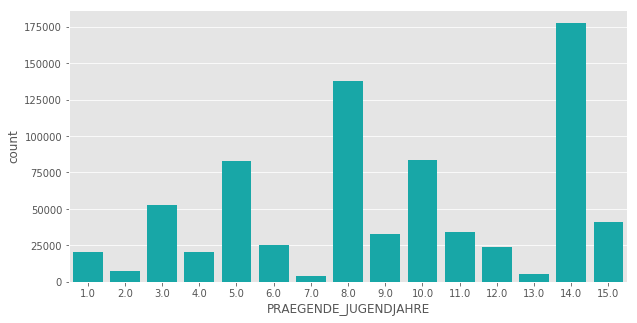

In [167]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
plt.style.use('ggplot')
fig, ax1 = plt.subplots(figsize=(10,5))
sns.countplot(data=df_lowNaN,
              x='PRAEGENDE_JUGENDJAHRE',
              color="c",
              ax=ax1);

In [168]:
df_lowNaN.PRAEGENDE_JUGENDJAHRE.value_counts().sort_values(ascending=False)

14.0    177574
8.0     137903
10.0     83394
5.0      83112
3.0      52758
15.0     40803
11.0     34385
9.0      32939
6.0      25311
12.0     23925
4.0      20185
1.0      20106
2.0       7387
13.0      5520
7.0       3939
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [169]:
print('Percentage of NaNs"s avg in PRAEGENDE_JUGENDJAHRE:',df_lowNaN.PRAEGENDE_JUGENDJAHRE.isnull().mean()*100)

Percentage of NaNs"s avg in PRAEGENDE_JUGENDJAHRE: 3.29167220614


In [170]:
# based on the info get from the Data_Dictionary
decade = {     1: 1, 
               2: 1, 
               3: 2, 
               4: 2,
               5: 3,
               6: 3, 
               7: 3,
               8: 4,
               9: 4, 
               10: 5, 
               11: 5, 
               12: 5, 
               13: 5,
               14: 6, 
               15: 6
         }
#Mainstream --> 1 and Avantage--->2
movement = {     1: 1,
                 3: 1, 
                 5: 1, 
                 8: 1, 
                 10: 1, 
                 12: 1, 
                 14: 1,
                 2: 2, 
                 4: 2,
                 6: 2, 
                 7: 2, 
                 9: 2, 
                 11: 2, 
                 13: 2, 
                 15: 2
                }
df_lowNaN['DECADE'] = df_lowNaN['PRAEGENDE_JUGENDJAHRE'].map(decade)
df_lowNaN['MOVEMENT'] = df_lowNaN['PRAEGENDE_JUGENDJAHRE'].map(movement)

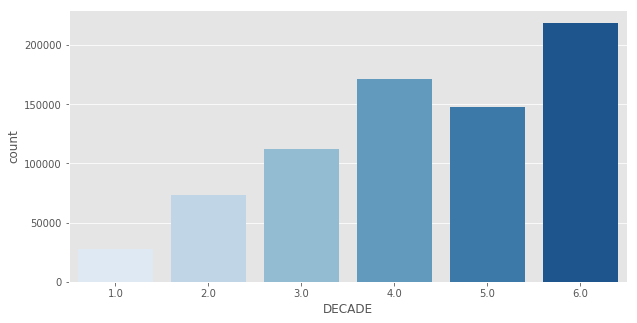

In [171]:
# visualize the decade after creating its coloumn
fig, ax1 = plt.subplots(figsize=(10,5))
sns.countplot(data=df_lowNaN,
              x='DECADE',
              palette="Blues",
              ax=ax1);

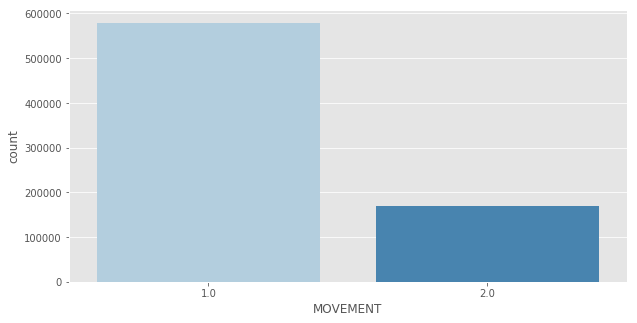

In [172]:
# visualize the movement after creating its coloumn
fig, ax1 = plt.subplots(figsize=(10,5))
sns.countplot(data=df_lowNaN,
              x='MOVEMENT',
              palette="Blues",
              ax=ax1);

In [173]:
# drop the original coloumn
df_lowNaN.drop(['PRAEGENDE_JUGENDJAHRE'], axis = 1, inplace=True)

In [174]:
###############################################################################################################################

In [175]:
# 2)CAMEO_INTL_2015
df_lowNaN.CAMEO_INTL_2015.sample(10)

176929    24
642297    23
747793    51
62162     14
17513     25
153099    31
722555    43
556449    45
734161    41
347674    34
Name: CAMEO_INTL_2015, dtype: object

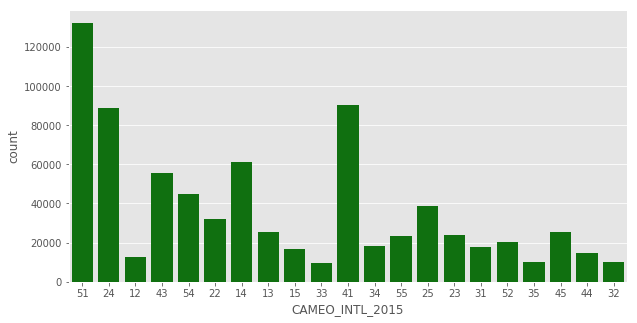

In [176]:
# visualize CAMEO_INTL_2015
plt.style.use('ggplot')
fig, ax1 = plt.subplots(figsize=(10,5))
sns.countplot(data=df_lowNaN,
              x='CAMEO_INTL_2015',
              color="g",
              ax=ax1);

In [177]:
df_lowNaN.CAMEO_INTL_2015.value_counts().sort_values(ascending=False)

51    132086
41     90430
24     88559
14     60994
43     55429
54     44745
25     38587
22     31990
45     25610
13     25477
23     24111
55     23440
52     20258
34     18111
31     17721
15     16645
44     14502
12     12795
35     10139
32     10087
33      9571
Name: CAMEO_INTL_2015, dtype: int64

In [178]:
print('Percentage of NaNs"s avg in CAMEO_INTL_2015:',df_lowNaN.CAMEO_INTL_2015.isnull().mean()*100)

Percentage of NaNs"s avg in CAMEO_INTL_2015: 0.446083410886


In [179]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# function to break up codes
def breakCode(feature, digit):
    # make sure first that it's not a NaN value
    if not pd.isna(feature):
        if digit == 'wealth':
            return int(str(feature)[0]) # access on coloumn
        elif digit == 'life_stage':
            return int(str(feature)[1]) # access on row
    return feature
 
df_lowNaN['WEALTH'] = df_lowNaN['CAMEO_INTL_2015'].apply(breakCode, digit='wealth')
df_lowNaN['LIFE_STAGE'] = df_lowNaN['CAMEO_INTL_2015'].apply(breakCode, digit='life_stage')

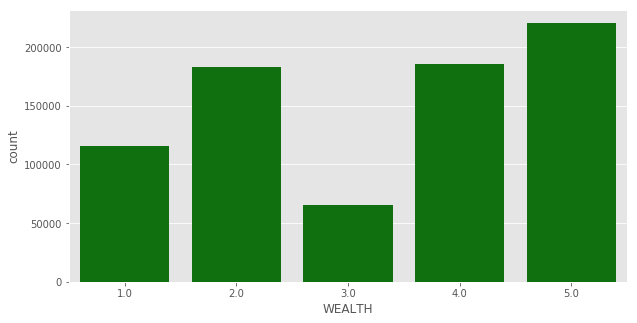

In [180]:
# visualize Wealth
fig, ax1 = plt.subplots(figsize=(10,5))
sns.countplot(data=df_lowNaN,
              x='WEALTH',
              color = "g",
              ax=ax1);

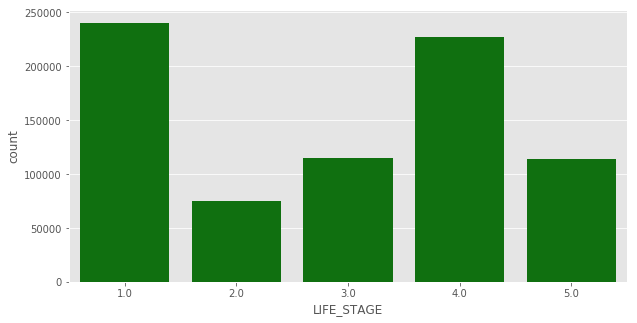

In [181]:
# visualize Life_stage
fig, ax1 = plt.subplots(figsize=(10,5))
sns.countplot(data=df_lowNaN,
              x='LIFE_STAGE',
              color = "g",
              ax=ax1);

In [182]:
# drop CAMEO_INTL_2015
df_lowNaN.drop(['CAMEO_INTL_2015'], axis = 1, inplace=True)

In [183]:
from pandas.api.types import is_numeric_dtype

assert(sum([is_numeric_dtype(df_lowNaN[col]) for col in df_lowNaN.columns]) == df_lowNaN.shape[1])

# quick check
#if (sum([is_numeric_dtype(df_lowNaN[col]) for col in df_lowNaN.columns]) == df_lowNaN.shape[1]):
#    print("Ready")

In [184]:
df_lowNaN.shape

(774743, 68)

#### Discussion 1.2.2: Engineer Mixed-Type Features

### 1) PRAEGENDE_JUGENDJAHRE:
- This point consists of the following (based on Data_Dictinoary.md): 
   -  1: 40s - war years (Mainstream, E+W)
   -  2: 40s - reconstruction years (Avantgarde, E+W)
   -  3: 50s - economic miracle (Mainstream, E+W)
   -  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
   -  5: 60s - economic miracle (Mainstream, E+W)
   -  6: 60s - generation 68 / student protestors (Avantgarde, W)
   -  7: 60s - opponents to the building of the Wall (Avantgarde, E)
   -  8: 70s - family orientation (Mainstream, E+W)
   -  9: 70s - peace movement (Avantgarde, E+W)
   - 10: 80s - Generation Golf (Mainstream, W)
   - 11: 80s - ecological awareness (Avantgarde, W)
   - 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
   - 13: 80s - Swords into ploughshares (Avantgarde, E)
   - 14: 90s - digital media kids (Mainstream, E+W)
   - 15: 90s - ecological awareness (Avantgarde, E+W)
 - It's split into 2 major subpoints which are **DECADES** from(40-90s) and **MOVEMENT** (between Avantgarde and Mainstream)
 - Steps taken:
    - A dict is created to map decades 
    - A dict is created to map movement (Mainstream --> 1 and Avantage---> 2)
    - 2 new coloumns are added (DECADES and MOVEMENT) 
    - Original coloumn is dropped
    - Plots are created after nearly each step for a better visualization and a good understanding of data since it's easier to pick information from diagrams than just reading numbers which might be confusing
    

### 2) CAMEO_INTL_2015
- This point consists of the following (based on Data_Dictinoary.md): 
  - -1: unknown
  - 11: Wealthy Households - Pre-Family Couples & Singles
  - 12: Wealthy Households - Young Couples With Children
  - 13: Wealthy Households - Families With School Age Children
  - 14: Wealthy Households - Older Families &  Mature Couples
  - 15: Wealthy Households - Elders In Retirement
  - 21: Prosperous Households - Pre-Family Couples & Singles
  - 22: Prosperous Households - Young Couples With Children
  - 23: Prosperous Households - Families With School Age Children
  - 24: Prosperous Households - Older Families & Mature Couples
  - 25: Prosperous Households - Elders In Retirement
  - 31: Comfortable Households - Pre-Family Couples & Singles
  - 32: Comfortable Households - Young Couples With Children
  - 33: Comfortable Households - Families With School Age Children
  - 34: Comfortable Households - Older Families & Mature Couples
  - 35: Comfortable Households - Elders In Retirement
  - 41: Less Affluent Households - Pre-Family Couples & Singles
  - 42: Less Affluent Households - Young Couples With Children
  - 43: Less Affluent Households - Families With School Age Children
  - 44: Less Affluent Households - Older Families & Mature Couples
  - 45: Less Affluent Households - Elders In Retirement
  - 51: Poorer Households - Pre-Family Couples & Singles
  - 52: Poorer Households - Young Couples With Children
  - 53: Poorer Households - Families With School Age Children
  - 54: Poorer Households - Older Families & Mature Couples
  - 55: Poorer Households - Elders In Retirement
  - XX: unknown
- It gives information about 2 social living (one for **WEALTH** and the second for the **LIFE_STAGE**)
- Steps taken:
  - Apply function **breakCode** along an axis of the DataFrame to break up between wealth and life stage and save the new coloumns created
  - Original coloumn is dropped
  - Better visualization and good undersatnding through diagrams
  
- NOTE:
the shape of dataset is reduced (from (891221, 85) to (774743, 68))

### 3) Complete Feature Selection:
- In the next step, 'PLZ8_BAUMAX','LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB' will be dropped for some reasons:
  - mixture only presents 6%
  - After a careful look to the Data_Dictionary, I've found that:
    - PLZ8_BAUMAX: describes most common building type within the PLZ8 region (family homes and business buildings) which could be a non-affecting point on the dataset, specially that family homes are "majority" which could be an information derivative from CAMEO_INTL_2015 
    - LP_LEBENSPHASE_FEIN: again it describes life stage and fine scale which are nearely covered by CAMEO_INTL_2015
    - LP_LEBENSPHASE_GROB: describes again life stage and rough scale, it could be considered as a repetitive information.
      This coloumn and the one below it could be combined as CAMEO_INTL_2015 
  - The shape of dataset will be reduced from (774743, 68) to (774743, 65)
  - Interpolate function used to fill NA values in the dataframe

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [185]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

In [186]:
df_lowNaN.drop(['PLZ8_BAUMAX','LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB'], axis = 1, inplace=True)

In [187]:
df_lowNaN.shape

(774743, 65)

In [188]:
df_lowNaN.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_TRADV', 'SOHO_KZ', 'VERS_TYP', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'KBA05_ANTG1',
       'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM',
       'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO',
       'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1',
       'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ',
 

In [189]:
df_lowNaN.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
1,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,2.0,2.0,4.0
2,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
3,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
4,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


In [190]:
for col in df_lowNaN.columns:
        df_lowNaN[col] = df_lowNaN[col].interpolate(limit_direction='both')

In [191]:
df_lowNaN.isnull().sum().sum()

0

In [192]:
df_lowNaN.shape

(774743, 65)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [102]:
missing_data_encode = dict(zip(feat_info.attribute, feat_info.missing_or_unknown))
#missing_data_encode

In [209]:
# convert missing value codes into NaNs, ...
def missingData_toNaN(df,debug=False):
    for col in missing_data_encode.keys():
        if debug:
            print(col, 'nans before: ', df[col].isnull().sum())
        df.loc[df[col].isin(missing_data_encode[col]), col] = np.nan
        if debug:
            print(col, 'nans after: ', df[col].isnull().sum(), '\n')
    print(df.shape)
    return df


# remove selected columns and rows, ...
def remove_col(df):
    print('removing col')
    df = df.drop(columns=missing_20, axis=1)
    print(df.shape)
    return  df

def remove_row(df):
    threshhold = 0.1
    df['R_percNaN'] = df.isnull().mean(axis=1)
    
    df_lowNaN = df.loc[df['R_percNaN'] < threshhold, :].\
                                drop(columns='R_percNaN', axis=1)
    print(df_lowNaN.shape)
    return df_lowNaN

#    df['R_percNaN'] = df.isnull().mean(axis=1)
#    df_NaN = df.loc[df['R_percNaN'],:] 
#    if df_NaN < threshold:
#        df_NaN=df_NaN.drop(columns='R_percNaN', axis=1)
#    else:
#        pass
#    print('removed row')
#    return df_NaN    

# select, re-encode, and engineer column values.
# 1) reencode Categorical Feature
def reencode_categorical(df,feature):
    df[feature]=df[feature].replace({'W':1,'O':0})
    df_categorical = feat_info[feat_info.type == 'categorical'].attribute
    nunique = df[df_categorical].nunique()
    encoded = nunique[nunique > 2]
    df = df.drop(columns=encoded.index, axis=0)
    print('encoded categorical')
    print(df.shape)
    return df
# 2) engineer Mixture Feature
def eng_mixture(df):
    decade = {1: 1,  2: 1, 3: 2, 4: 2, 5: 3, 6: 3, 7: 3, 8: 4, 9: 4, 10: 5, 11: 5, 12: 5, 13: 5, 14: 6, 15: 6}
    movement = {1: 1, 3: 1, 5: 1, 8: 1, 10: 1, 12: 1, 14: 1, 2: 2, 4: 2, 6: 2, 7: 2, 9: 2, 11: 2, 13: 2, 15: 2}
    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade)
    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement)
    df['WEALTH'] = df['CAMEO_INTL_2015'].apply(breakCode, digit='wealth')
    df['LIFE_STAGE'] = df['CAMEO_INTL_2015'].apply(breakCode, digit='life_stage')
    #df = df.drop(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015'])
    print('eng mixture')
    print(df.shape)
    return df





# Put in code here to execute all main cleaning steps:
def clean_data(df):
    df_converted = missingData_toNaN(df)
    print('DONE Converted into NaN')
    df_removedCol = remove_col(df_converted)
    print('DONE dropping col')
    df_removedRow = remove_row(df_removedCol)
    print('DONE dropping row')
    df_encoded =  reencode_categorical(df_removedRow,'OST_WEST_KZ')
    print('DONE encoding OST_WEST_KZ')
    df_eng = eng_mixture(df_encoded)
    print('DONE engineering Mixture')
    df_drop = df_eng.drop(['PLZ8_BAUMAX','LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB'],axis=1)
    print('DONE dropping Mix col')
    #df_drop.columns = df_lowNaN.columns
    for col in df_drop.columns:
        df_drop[col] = df_drop[col].interpolate(limit_direction='both')
    print('Test Checked')
    return df_drop    
# Return the cleaned dataframe

In [69]:
'''
Some good references for better understanding:
- https://towardsdatascience.com/data-wrangling-with-pandas-5b0be151df4e
- https://seaborn.pydata.org/generated/seaborn.countplot.html
- https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf
- https://elitedatascience.com/python-data-wrangling-tutorial
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html
- https://towardsdatascience.com/how-to-use-ggplot2-in-python-74ab8adec129
- https://www.geeksforgeeks.org/python-map-function/
- https://www.geeksforgeeks.org/python-pandas-dataframe-interpolate/
- https://www.geeksforgeeks.org/python-pandas-dataframe-isin/
- https://www.analyticsvidhya.com/blog/2016/12/introduction-to-feature-selection-methods-with-an-example-or-how-to-select-the-right-variables/
'''

'\nSome good references for better understanding:\n- https://towardsdatascience.com/data-wrangling-with-pandas-5b0be151df4e\n- https://seaborn.pydata.org/generated/seaborn.countplot.html\n- https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf\n- https://elitedatascience.com/python-data-wrangling-tutorial\n- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html\n- https://towardsdatascience.com/how-to-use-ggplot2-in-python-74ab8adec129\n- https://www.geeksforgeeks.org/python-map-function/\n- https://www.geeksforgeeks.org/python-pandas-dataframe-interpolate/\n- https://www.geeksforgeeks.org/python-pandas-dataframe-isin/\n- https://www.analyticsvidhya.com/blog/2016/12/introduction-to-feature-selection-methods-with-an-example-or-how-to-select-the-right-variables/\n'

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [70]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

''' already done in the previous lines '''

' already done in the previous lines '

In [71]:
# Apply feature scaling to the general population demographics data.
# importing libs
from sklearn.preprocessing import StandardScaler

stdScaler = StandardScaler()
df_scale = pd.DataFrame(stdScaler.fit_transform(df_lowNaN))
df_scale.columns = df_lowNaN.columns

In [72]:
df_scale.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,-1.76346,0.958422,-1.488785,1.540017,-1.044684,1.468541,0.981043,1.327209,-0.531136,1.065592,...,0.413629,1.428467,0.559152,-0.174198,-0.133255,0.678124,1.157782,-0.546181,1.178441,-1.258698
1,0.19940,0.958422,-1.488785,0.867244,-1.770775,-0.568811,0.263375,1.327209,1.882757,1.065592,...,-0.964435,0.398849,0.559152,-0.174198,-0.133255,-0.795034,1.157782,1.858969,-0.870639,0.759533
2,1.18083,0.958422,0.689233,-0.478302,1.133590,-0.568811,-1.171961,-0.818216,-0.531136,-0.273227,...,-0.964435,-0.630769,0.559152,-1.178561,-1.003080,-0.058455,-0.225029,-0.546181,-1.553666,-0.585954
3,0.19940,-1.043381,0.689233,0.194471,0.407498,-1.247929,0.263375,-0.818216,-0.531136,1.065592,...,0.413629,-0.630769,-0.342501,0.830166,0.301657,1.414702,-0.225029,-0.546181,0.495415,0.086789
4,-1.76346,0.958422,-0.036773,-1.151076,1.133590,-0.568811,-0.454293,1.327209,-0.531136,1.065592,...,0.413629,1.428467,1.460804,-1.178561,-1.003080,-0.058455,-1.607839,-0.546181,1.178441,0.759533


### Discussion 2.1: Apply Feature Scaling

- The data is clean from any NaN value in section1.2
- Applied StandardScaler on data saved in df_scale to transform data with a mean value 0 and standard deviation of 1

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [73]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

pca = PCA()
df_pca = pca.fit_transform(df_scale)

n_components = len(pca.explained_variance_ratio_)
print(n_components)

65


In [74]:
values = pca.explained_variance_ratio_

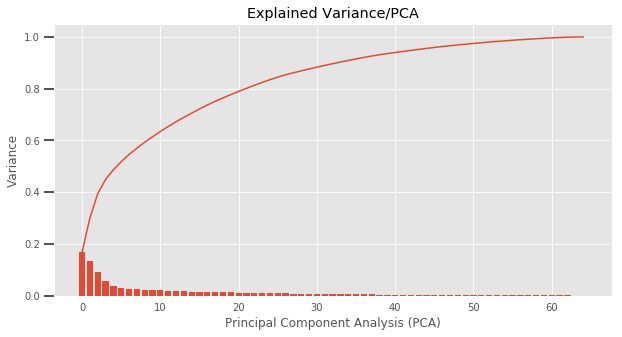

In [75]:
# Investigate the variance accounted for by each principal component.
def plot_pca(pca,n_components,values):
    index = np.arange(n_components)
    plt.figure(figsize=(10,5))
    ax = plt.subplot(111) # 1x1 fisrt subplot
    
    cum_values = np.cumsum(values)
    ax.bar(index, values)
    ax.plot(index, cum_values)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=10)
 
    ax.set_xlabel("Principal Component Analysis (PCA)")
    ax.set_ylabel("Variance")
    plt.title('Explained Variance/PCA')
    
plot_pca(df_pca,65,values)

In [76]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_retain = PCA(n_components=40)
df_retain = pca_retain.fit_transform(df_pca)

### Discussion 2.2: Perform Dimensionality Reduction

Dimensionality Reduction is considered an important process to shrink our data
- Applying PCA (Principle Component Analysis) to get the most amount of variability of the dataset
- From the plot (Varience/Cumulative), we could estimate the **40** is a good number for the components to retrain, since after it, the curve starts to be constant (small changes occurs). 


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [77]:
import operator
import pprint

def pca_weights(pca, i):
    weight_map = {}
    for counter, feature in enumerate(df_scale.columns):
        weight_map[feature] = pca.components_[i][counter]
    
    sorted_weights = sorted(weight_map.items(), key=operator.itemgetter(1), reverse=True)
    
    return sorted_weights

weights = pca_weights(pca_retain,1)
pprint.pprint(weights)

[('ANREDE_KZ', 1.0000000000000004),
 ('MOBI_REGIO', 2.6759856384164429e-09),
 ('BALLRAUM', 2.542391055410221e-09),
 ('GEBAEUDETYP_RASTER', 2.0640575786480614e-09),
 ('KKK', 1.7481769655482688e-09),
 ('KBA05_GBZ', 1.4273055482416516e-09),
 ('KBA05_ANTG2', 1.3655450259016308e-09),
 ('KBA05_ANTG4', 1.1091643082212781e-09),
 ('WOHNLAGE', 9.7169539649412158e-10),
 ('PLZ8_ANTG4', 6.74867353137164e-10),
 ('PLZ8_HHZ', 6.5616261130160693e-10),
 ('PLZ8_ANTG3', 3.0643068426840724e-10),
 ('KBA05_ANTG1', 3.0101798087302152e-10),
 ('ANZ_PERSONEN', 2.8118297610760298e-10),
 ('ANZ_HAUSHALTE_AKTIV', 2.792374347453019e-10),
 ('EWDICHTE', 2.7202341471547259e-10),
 ('ANZ_TITEL', 2.1390727793907118e-10),
 ('RELAT_AB', 1.6936682204511039e-10),
 ('VERS_TYP', 9.3651108075007808e-11),
 ('SOHO_KZ', 8.0552930589436879e-11),
 ('ORTSGR_KLS9', 7.4673047300977363e-11),
 ('MIN_GEBAEUDEJAHR', 5.5688230639468913e-11),
 ('SEMIO_ERL', 4.2329824248146978e-11),
 ('SEMIO_DOM', 2.3045673009954744e-11),
 ('SEMIO_SOZ', 1.07101

In [78]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

In [78]:
feature_select = pd.DataFrame(pca.components_,columns=df_scale.columns).T
feature_select[0].sort_values()

MOBI_REGIO              -0.242167
PLZ8_ANTG1              -0.226872
KBA05_ANTG1             -0.225012
KBA05_GBZ               -0.217794
FINANZ_MINIMALIST       -0.215611
KONSUMNAEHE             -0.169970
PLZ8_GBZ                -0.167817
INNENSTADT              -0.167581
BALLRAUM                -0.130102
LIFE_STAGE              -0.123372
GEBAEUDETYP_RASTER      -0.117422
ALTERSKATEGORIE_GROB    -0.111735
FINANZ_VORSORGER        -0.106672
GREEN_AVANTGARDE        -0.105925
MOVEMENT                -0.103649
WOHNLAGE                -0.090153
ANZ_PERSONEN            -0.079365
KBA13_ANZAHL_PKW        -0.078660
SEMIO_ERL               -0.070423
SEMIO_LUST              -0.067682
MIN_GEBAEUDEJAHR        -0.061444
WOHNDAUER_2008          -0.058928
OST_WEST_KZ             -0.053054
ONLINE_AFFINITAET       -0.047867
SEMIO_VERT              -0.040443
RETOURTYP_BK_S          -0.013775
ANZ_TITEL               -0.003883
SOHO_KZ                 -0.001983
SEMIO_KRIT               0.006482
ANREDE_KZ     

In [79]:
feature_select = pd.DataFrame(pca.components_,columns=df_scale.columns).T
feature_select[1].sort_values()

SEMIO_REL               -0.258143
DECADE                  -0.251698
FINANZ_SPARER           -0.239735
SEMIO_TRADV             -0.233207
SEMIO_PFLICHT           -0.231935
FINANZ_UNAUFFAELLIGER   -0.228271
SEMIO_KULT              -0.221498
FINANZ_ANLEGER          -0.208097
SEMIO_FAM               -0.185111
SEMIO_RAT               -0.173576
SEMIO_MAT               -0.164366
ONLINE_AFFINITAET       -0.162003
SEMIO_SOZ               -0.103488
PLZ8_ANTG1              -0.082373
KBA05_GBZ               -0.080305
MOBI_REGIO              -0.079942
KBA05_ANTG1             -0.070070
INNENSTADT              -0.069941
SEMIO_VERT              -0.067400
PLZ8_GBZ                -0.065149
KONSUMNAEHE             -0.063806
ANZ_PERSONEN            -0.058377
HEALTH_TYP              -0.058355
BALLRAUM                -0.057722
WOHNLAGE                -0.056164
MIN_GEBAEUDEJAHR        -0.046640
GEBAEUDETYP_RASTER      -0.038750
KBA13_ANZAHL_PKW        -0.032643
OST_WEST_KZ             -0.022375
KBA05_ANTG2   

In [80]:
feature_select = pd.DataFrame(pca.components_,columns=df_scale.columns).T
feature_select[2].sort_values()

ANREDE_KZ               -0.369118
SEMIO_KAEM              -0.337296
SEMIO_DOM               -0.313063
SEMIO_KRIT              -0.274307
SEMIO_RAT               -0.217110
FINANZ_ANLEGER          -0.189520
SEMIO_ERL               -0.175559
DECADE                  -0.106251
FINANZ_SPARER           -0.105605
FINANZ_UNAUFFAELLIGER   -0.097872
SEMIO_PFLICHT           -0.078822
SEMIO_TRADV             -0.078660
ONLINE_AFFINITAET       -0.052971
FINANZ_HAUSBAUER        -0.045980
PLZ8_ANTG1              -0.044592
INNENSTADT              -0.043324
KONSUMNAEHE             -0.037424
PLZ8_GBZ                -0.037070
BALLRAUM                -0.035600
GEBAEUDETYP_RASTER      -0.029351
MOBI_REGIO              -0.027554
KBA05_GBZ               -0.025087
WOHNLAGE                -0.024413
HH_EINKOMMEN_SCORE      -0.022663
KBA13_ANZAHL_PKW        -0.022458
KBA05_ANTG1             -0.021071
HEALTH_TYP              -0.019810
MIN_GEBAEUDEJAHR        -0.017240
KKK                     -0.015316
OST_WEST_KZ   

In [82]:
'''
Some good references:
- https://www.geeksforgeeks.org/enumerate-in-python/
- https://pandas.pydata.org/pandas-docs/version/0.22.0/generated/pandas.DataFrame.reset_index.html
- https://docs.scipy.org/doc/numpy/reference/generated/numpy.concatenate.html
- https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
'''

'\nSome good references:\n- https://www.geeksforgeeks.org/enumerate-in-python/\n- https://pandas.pydata.org/pandas-docs/version/0.22.0/generated/pandas.DataFrame.reset_index.html\n- https://docs.scipy.org/doc/numpy/reference/generated/numpy.concatenate.html\n- https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html\n'

### Discussion 2.3: Interpret Principal Components
- First Component: features such as Movement patterns, Building Type are negatively correlated, however, other features as Number of 6-10 family houses in the PLZ8 region and Likelihood of children in household are positively correlated.
- Second Component: Personality typology (especially :religious,..) is negatively correlated, however, we can find estimated age getting positive correlation
- Third Component: Dreamful typology got highest positive correlation and the gender got the negative one.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [81]:
# Over a number of different cluster counts...
    # run k-means clustering on the data and...
    # compute the average within-cluster distances.

from sklearn.cluster import KMeans

def get_kmeans(data, center):
    
    kmeans = KMeans(n_clusters = center)
    model = kmeans.fit(data)
    scores = np.abs(model.score(data))
    return scores
    

In [ ]:
scores = []
centers = list(range(1,25,2))
print(centers)

for center in centers:
    output = get_kmeans(df_retain,center)
    print(output)
    scores.append(output)
print(scores)    

In [82]:
# in case ~ to not repeat the last process (takes time)
centers = list(range(1,25,2))
scores=[47114929.997800186, 37542839.391035646, 34112800.406813428, 31752311.879460048, 30266477.537795015, 28951165.388485525, 28206799.109717578, 27352843.278914124, 27192665.843297206, 26140545.394511774, 25679975.600370068, 25323688.729474325]

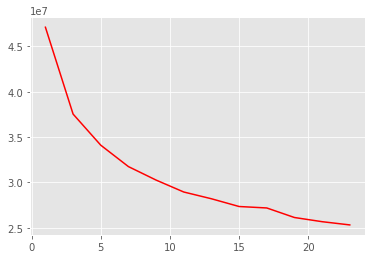

In [83]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(centers,scores,color='red')

In [84]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters = 10)
result = kmeans.fit_predict(df_retain)

### Discussion 3.1: Apply Clustering to General Population

- Applying Kmeans to cluster the dataset
- From the curve, we could deduce that **10** is a good point to choose for n_clusters since the curve starts to decrease from around 5 to 15


### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [225]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',delimiter=';')

In [226]:
customers.shape

(191652, 85)

In [227]:
customers_clean = clean_data(customers)

(191652, 85)
DONE Converted into NaN
removing col
(191652, 79)
DONE dropping col
(133427, 79)
DONE dropping row
encoded categorical
(133427, 66)
DONE encoding OST_WEST_KZ
eng mixture
(133427, 70)
DONE engineering Mixture
DONE dropping Mix col
Test Checked


In [228]:
customers_clean.shape

(133427, 67)

In [229]:
customers_clean.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ',
       'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST',
       'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM',
       'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SOHO_KZ', 'VERS_TYP',
       'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_INTL_2015',
       'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ',
       'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK',
       'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW',
       'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANT

In [230]:
customers_clean.drop(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015'], axis=1,inplace=True)

In [231]:
customers_clean.shape

(133427, 65)

In [217]:
#customers_clean =customers_clean[~customers_clean.isin([np.nan,np.inf, -np.inf]).any(1)]
#customers_clean.shape

(133427, 65)

In [232]:
customers_clean_trans = pd.DataFrame(stdScaler.transform(customers_clean))
customers_clean_trans.columns = customers_clean.columns
#customers_clean[customers_clean.columns] = stdScaler.transform(customers_clean[customers_clean.columns].as_matrix())

In [233]:
customers_pca = pca_retain.transform(customers_clean_trans)

In [234]:
#kmeans = KMeans(n_clusters = 10)
result_customer = kmeans.predict(customers_pca)

In [ ]:
'''
Reference:
- https://datascience.stackexchange.com/questions/26886/valueerror-input-contains-nan-infinity-or-a-value-too-large-for-dtypefloat64
- https://stackoverflow.com/questions/43675665/when-scale-the-data-why-the-train-dataset-use-fit-and-transform-but-the-te
'''

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [235]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

result_customer = pd.Series(result_customer)
customer_dist = result_customer.value_counts().sort_index()
result = pd.Series(result)
population_dist = result.value_counts().sort_index()
final_df = pd.DataFrame([population_dist,customer_dist]).T
final_df.columns = ['population_count','customer_count']
final_df

,population_count,customer_count
0,59225,389
1,67736,14301
2,96445,78742
3,83825,1271
4,86337,18923
5,57673,526
6,81446,4680
7,82186,2980
8,100232,10210
9,59638,1405


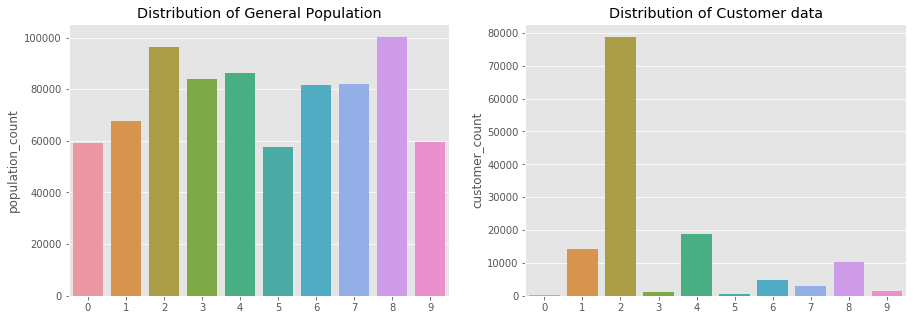

In [236]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1)
sns.barplot(x=final_df.index,y='population_count', data = final_df)
plt.title("Distribution of General Population")
ax2 = fig.add_subplot(1,2,2)
sns.barplot(x=final_df.index,y='customer_count', data = final_df)
plt.title("Distribution of Customer data")
plt.show()

In [239]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
cc3 = kmeans.cluster_centers_[3]
cc3 = pd.Series(cc3)
cc3.sort_values(ascending=False, inplace=True)
cc3.head()

0     4.360341
8     0.429716
3     0.317440
9     0.143314
37    0.138175
dtype: float64

In [240]:
feature_select[3].sort_values()

WOHNLAGE                -0.285069
KKK                     -0.249554
HH_EINKOMMEN_SCORE      -0.245049
BALLRAUM                -0.219341
INNENSTADT              -0.203188
REGIOTYP                -0.190528
KONSUMNAEHE             -0.130767
WEALTH                  -0.129553
FINANZ_ANLEGER          -0.116295
FINANZ_HAUSBAUER        -0.109648
W_KEIT_KIND_HH          -0.082936
KBA05_ANTG3             -0.071451
GEBAEUDETYP_RASTER      -0.063027
KBA05_ANTG4             -0.047398
ALTERSKATEGORIE_GROB    -0.045590
ANZ_HAUSHALTE_AKTIV     -0.042772
MIN_GEBAEUDEJAHR        -0.032117
PLZ8_ANTG1              -0.030043
SEMIO_KULT              -0.029984
SEMIO_ERL               -0.025232
SEMIO_FAM               -0.019758
FINANZ_VORSORGER        -0.017318
SEMIO_VERT              -0.013688
SEMIO_LUST              -0.003979
RETOURTYP_BK_S          -0.001913
FINANZ_SPARER           -0.000642
SEMIO_REL               -0.000598
SEMIO_SOZ                0.001340
SOHO_KZ                  0.002194
HEALTH_TYP    

In [237]:
cc8 = kmeans.cluster_centers_[8]
cc8 = pd.Series(cc8)
cc8.sort_values(ascending=False, inplace=True)
cc8.head()

1     4.096539
0     1.902935
7     0.218440
23    0.107569
25    0.101810
dtype: float64

In [238]:
feature_select[8].sort_values()

VERS_TYP                -0.478379
HEALTH_TYP              -0.432423
OST_WEST_KZ             -0.138255
DECADE                  -0.131043
KBA05_ANTG2             -0.129353
FINANZ_UNAUFFAELLIGER   -0.124792
FINANZ_SPARER           -0.117050
W_KEIT_KIND_HH          -0.102244
SEMIO_KRIT              -0.099590
SEMIO_SOZ               -0.075421
PLZ8_ANTG2              -0.046118
SEMIO_DOM               -0.044955
ANZ_HH_TITEL            -0.042689
INNENSTADT              -0.035629
HH_EINKOMMEN_SCORE      -0.032823
FINANZ_ANLEGER          -0.029970
PLZ8_ANTG1              -0.022713
KBA05_GBZ               -0.020643
BALLRAUM                -0.017669
KBA05_ANTG3             -0.012449
WOHNLAGE                -0.012363
ANZ_TITEL               -0.011456
GREEN_AVANTGARDE        -0.006559
MOVEMENT                -0.005946
SEMIO_VERT               0.000256
ALTERSKATEGORIE_GROB     0.002974
SEMIO_FAM                0.007240
SOHO_KZ                  0.009883
ANZ_HAUSHALTE_AKTIV      0.011008
MOBI_REGIO    

In [241]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
cc2 = kmeans.cluster_centers_[2]
cc2 = pd.Series(cc2)
cc2.sort_values(ascending=False, inplace=True)
cc2.head()


2     2.821738
0     2.076760
1     1.916838
27    0.258190
20    0.135227
dtype: float64

In [242]:
feature_select[2].sort_values()

ANREDE_KZ               -0.369118
SEMIO_KAEM              -0.337296
SEMIO_DOM               -0.313063
SEMIO_KRIT              -0.274307
SEMIO_RAT               -0.217110
FINANZ_ANLEGER          -0.189520
SEMIO_ERL               -0.175559
DECADE                  -0.106251
FINANZ_SPARER           -0.105605
FINANZ_UNAUFFAELLIGER   -0.097872
SEMIO_PFLICHT           -0.078822
SEMIO_TRADV             -0.078660
ONLINE_AFFINITAET       -0.052971
FINANZ_HAUSBAUER        -0.045980
PLZ8_ANTG1              -0.044592
INNENSTADT              -0.043324
KONSUMNAEHE             -0.037424
PLZ8_GBZ                -0.037070
BALLRAUM                -0.035600
GEBAEUDETYP_RASTER      -0.029351
MOBI_REGIO              -0.027554
KBA05_GBZ               -0.025087
WOHNLAGE                -0.024413
HH_EINKOMMEN_SCORE      -0.022663
KBA13_ANZAHL_PKW        -0.022458
KBA05_ANTG1             -0.021071
HEALTH_TYP              -0.019810
MIN_GEBAEUDEJAHR        -0.017240
KKK                     -0.015316
OST_WEST_KZ   

### Discussion 3.3: Compare Customer Data to Demographics Data

After studying the correlations and the afinity of the data, we can deduce:
- categories (like 8) are overrepresented
- categories (like 2) are underrepresented

**NOTES:**
- persons who are materialistic, purchasing power and sharing employement with community are overrepresented.
- persons who are dreamful, their movement affects them, share of unemployment in community are considered underrepresented.



> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.